In [4]:
!pip install mlem torchvision numpy --upgrade #tensorflow
!pip install mlem==0.4.6 --no-deps
!pip install iterative-telemetry==0.0.7 --ignore-requires-python --no-deps
!pip install pydantic==1.10.2 --no-deps
!pip install numpy==1.23.5

  Using cached mlem-0.4.12-py3-none-any.whl (218 kB)
  Using cached python_multipart-0.0.6-py3-none-any.whl (45 kB)
  Attempting uninstall: mlem
    Found existing installation: mlem 0.4.6
    Uninstalling mlem-0.4.6:
      Successfully uninstalled mlem-0.4.6
  Using cached mlem-0.4.6-py3-none-any.whl (214 kB)
  Attempting uninstall: mlem
    Found existing installation: mlem 0.4.12
    Uninstalling mlem-0.4.12:
      Successfully uninstalled mlem-0.4.12
ERROR: Ignored the following versions that require a different python version: 1.22.0 Requires-Python >=3.8; 1.22.1 Requires-Python >=3.8; 1.22.2 Requires-Python >=3.8; 1.22.3 Requires-Python >=3.8; 1.22.4 Requires-Python >=3.8; 1.23.0 Requires-Python >=3.8; 1.23.0rc1 Requires-Python >=3.8; 1.23.0rc2 Requires-Python >=3.8; 1.23.0rc3 Requires-Python >=3.8; 1.23.1 Requires-Python >=3.8; 1.23.2 Requires-Python >=3.8; 1.23.3 Requires-Python >=3.8; 1.23.4 Requires-Python >=3.8; 1.23.5 Requires-Python >=3.8; 1.24.0 Requires-Python >=3.8; 1.2

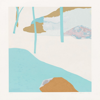

In [5]:
from PIL import Image

Image.open("/kaggle/input/art-price-dataset/artDataset/image_6.png").resize((100, 100))

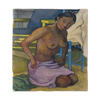

In [6]:
Image.open("/kaggle/input/image-data/images/6.png").resize((100, 100))

In [7]:
import pandas as pd

df = pd.read_csv("/kaggle/input/art-price-dataset/artDataset.csv")
df["image"] = [f'image_{i}.png' for i in range(1, len(df) + 1)]
df1 = pd.read_csv("/kaggle/input/image-data/output.csv")
df1["image"] = df1["image"].apply(lambda x: x.replace('images/',''))
df.head()

,Unnamed: 0,price,artist,title,yearCreation,signed,condition,period,movement,image
0,0,28.500 USD,Tommaso Ottieri,Bayreuth Opera,2021,Signed on verso,This work is in excellent condition.,Contemporary,Baroque,image_1.png
1,1,3.000 USD,Pavel Tchelitchew,Drawings of the Opera,First Half 20th Century,Signed and titled,Not examined out of frame.No obvious signs of ...,Post-War,Surrealism,image_2.png
2,2,5.000 USD,Leo Gabin,Two on Sidewalk,2016,"Signed, titled and dated on verso",This work is in excellent condition.,Contemporary,Abstract,image_3.png
3,3,5.000 USD,Matthias Dornfeld,Blumenszene,2010,"Signed, titled and dated on the reverse with t...",This work is in excellent condition.There is m...,Contemporary,Abstract,image_4.png
4,4,2.500 USD,Alexis Marguerite Teplin,Feverish Embarkation,2001,Signed on verso,This work is in excellent condition.,Contemporary,Abstract,image_5.png


In [8]:
df1.head()

,price,image
0,156250,1.png
1,463500,2.png
2,367500,3.png
3,90000,4.png
4,271500,5.png


In [9]:
import os

images = list(os.walk("/kaggle/input/art-price-dataset/artDataset"))[0][2]
images1 = list(os.walk("/kaggle/input/image-data/images"))[0][2]

prices = df.set_index("image").loc[images].price.map(lambda x: int(x.strip(" USD").replace(".", ""))).values
prices1 = df1.set_index("image").loc[images1].price.values

In [10]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

images_arrays = []
for i in images:
    img = load_img(f"/kaggle/input/art-price-dataset/artDataset/{i}", target_size=(224, 224, 3)) 
    images_arrays.append(img_to_array(img))
for i in images1:
    img = load_img(f"/kaggle/input/image-data/images/{i}", target_size=(224, 224, 3)) 
    images_arrays.append(img_to_array(img))
    
images_arrays = np.concatenate([i.reshape(1, 224, 224, 3) for i in images_arrays])
images_arrays.shape

(4554, 224, 224, 3)

In [11]:
prices_fin=np.concatenate([prices,prices1])

## prices

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.losses import mean_squared_logarithmic_error

# let's make a very strong suggestion that flipping and rotation
# doesn't influence the price of the high art
data_augmentations = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# Load the ResNet50 model
base_model = MobileNetV3Small(include_top=False, input_shape=(224, 224, 3))

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.1)(x) # add dropout to prevent overfitting
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# Freeze the base_model
base_model.trainable = False

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error', metrics=['mean_absolute_error'])
# val loss don't go less than 6700
# but, the constant loss is 12800

# Train the model on your regression dataset
hist=model.fit(images_arrays, prices_fin, epochs=500, validation_split=0.1)

Epoch 1/500
129/129 [==============================] - 6s 29ms/step - loss: 45.9891 - mean_absolute_error: 198310.1875 - val_loss: 41.4288 - val_mean_absolute_error: 212364.8125
Epoch 2/500
129/129 [==============================] - 3s 22ms/step - loss: 35.6176 - mean_absolute_error: 198279.8906 - val_loss: 36.2885 - val_mean_absolute_error: 212338.7656
Epoch 3/500
129/129 [==============================] - 3s 23ms/step - loss: 31.9294 - mean_absolute_error: 198256.3750 - val_loss: 33.2843 - val_mean_absolute_error: 212315.9375
Epoch 4/500
129/129 [==============================] - 3s 22ms/step - loss: 29.5739 - mean_absolute_error: 198235.1250 - val_loss: 31.1750 - val_mean_absolute_error: 212294.8750
Epoch 5/500
129/129 [==============================] - 3s 22ms/step - loss: 27.8217 - mean_absolute_error: 198215.1719 - val_loss: 29.5612 - val_mean_absolute_error: 212275.0312
Epoch 6/500
129/129 [==============================] - 3s 24ms/step - loss: 26.4751 - mean_absolute_error: 198

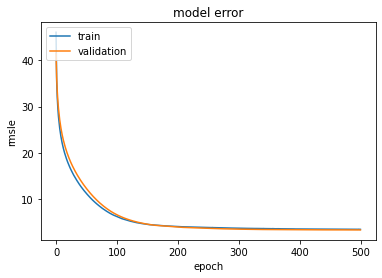

In [39]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model error")
    plt.ylabel("rmsle")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [48]:
def predict(x):
    return model.predict(np.expand_dims(x[:224,:224,:3], 0))[0][0]

num=78
img = img_to_array(Image.open(f"/kaggle/input/art-price-dataset/artDataset/image_{num}.png"))

print(f"prediction: {predict(img)}")
print(df.loc[df.image==f'image_{num}.png']['price'].values)

prediction: 4830.458984375
['2.500 USD']


In [49]:
from mlem.api import save

save(
    model, 
    "/kaggle/working/models/price_keras_preprocess", 
    preprocess=lambda x: np.expand_dims(x[:224,:224,:3], 0),
    postprocess=lambda x: {"price": np.max([500,np.array(x)[0][0]])},
    sample_data=img,
);

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [50]:
!zip -r price_keras_preprocess.zip models/price_keras_preprocess.mlem models/price_keras_preprocess

  adding: models/price_keras_preprocess.mlem (deflated 73%)
  adding: models/price_keras_preprocess/ (stored 0%)
  adding: models/price_keras_preprocess/model (deflated 11%)
  adding: models/price_keras_preprocess/postprocess (deflated 22%)
  adding: models/price_keras_preprocess/preprocess (deflated 21%)
